# Introduction

In recent years, the demand for accessible and automated document digitization tools has grown significantly, especially for visually impaired individuals, researchers, and industries that handle large volumes of printed materials. One crucial component of this automation is the ability to detect when a page is being flipped.

This project focuses on developing a machine learning model that can **predict whether a page is being flipped using a single image** extracted from smartphone videos. The dataset for this task consists of short, labeled video clips, with individual frames saved in sequence and annotated as either **flipping** or **not flipping**.

## Background and Motivation

The motivation behind this work is twofold:

- **Enhancing user experience:**  
  Accurate detection of page flips can dramatically improve mobile document scanning applications by automating the capture process, minimizing user effort, and increasing reliability.

- **Exploring computer vision challenges:**  
  Detecting an action like a page flip from a static frame — without temporal information — is a challenging task, pushing the boundaries of image understanding and classification.

## Project Plan

To tackle this problem, the project will proceed in three main phases:

1. **Exploratory Data Analysis (EDA):**  
   We will first analyze the dataset to understand its structure, label distribution, and the visual differences between flipping and non-flipping frames.

2. **Conventional Computer Vision Approaches:**  
   We will build and evaluate baseline models using traditional techniques such as feature extraction, edge detection, and classical classifiers.

3. **Deep Learning Models:**  
   Finally, we will leverage deep learning architectures, particularly convolutional neural networks (CNNs), to capture more complex patterns and significantly improve predictive performance.

## Evaluation Metrics

- Model performance will be evaluated based on the **F1 score**.
- A higher F1 score indicates a better balance between precision and recall.

## Goals

- Develop a system capable of predicting page flipping from a single image.
- Benchmark performance across conventional and deep learning methods.
- Understand the dataset and uncover challenges specific to single-frame action recognition.


## 1. Exploarory Data Analysis (EDA)

In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from skimage.feature import local_binary_pattern
from skimage.feature import hog
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
import squarify
import pytesseract
from PIL import Image
import base64
from groq import Groq
from gtts import gTTS
import tempfile
from playsound import playsound

In [4]:
# Define paths
data_dir = 'C:\\Users\\Ali Zoljodi\\Downloads\\images\\images'  # Change this to your dataset path
train_dir = os.path.join(data_dir, 'training')
test_dir = os.path.join(data_dir, 'testing')

In [5]:
# Function to get image paths and labels
def get_image_paths_labels(base_dir):
    image_paths = []
    labels = []
    for label in ['flip', 'notflip']:
        class_dir = os.path.join(base_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            image_paths.append(img_path)
            labels.append(label)
    return image_paths, labels


In [6]:
# Load data
train_paths, train_labels = get_image_paths_labels(train_dir)
test_paths, test_labels = get_image_paths_labels(test_dir)

In [7]:
# Summary statistics
def print_summary(paths, labels, dataset_name="Dataset"):
    print(f"{dataset_name} Summary:")
    print(f"Total images: {len(paths)}")
    counter = Counter(labels)
    for label, count in counter.items():
        print(f"{label}: {count} images")
    print("\n")

print_summary(train_paths, train_labels, "Training Set")
print_summary(test_paths, test_labels, "Testing Set")


Training Set Summary:
Total images: 2392
flip: 1162 images
notflip: 1230 images


Testing Set Summary:
Total images: 597
flip: 290 images
notflip: 307 images




# Dataset Summary Description

The dataset is organized into two main splits: **Training** and **Testing**, each containing images categorized into two classes , **flip** and **notflip**.

## Training Set
- Total Images: **2,392**
- **flip**: 1,162 images
- **notflip**: 1,230 images

## Testing Set
- Total Images: **597**
- **flip**: 290 images
- **notflip**: 307 images

## Observations
- The dataset maintains a fairly balanced distribution between the **flip** and **notflip** categories across both training and testing sets.
- This balance is beneficial, as it reduces the risk of model bias toward a particular class.
- A balanced dataset supports more reliable evaluation of model performance using classification metrics such as the F1 score.


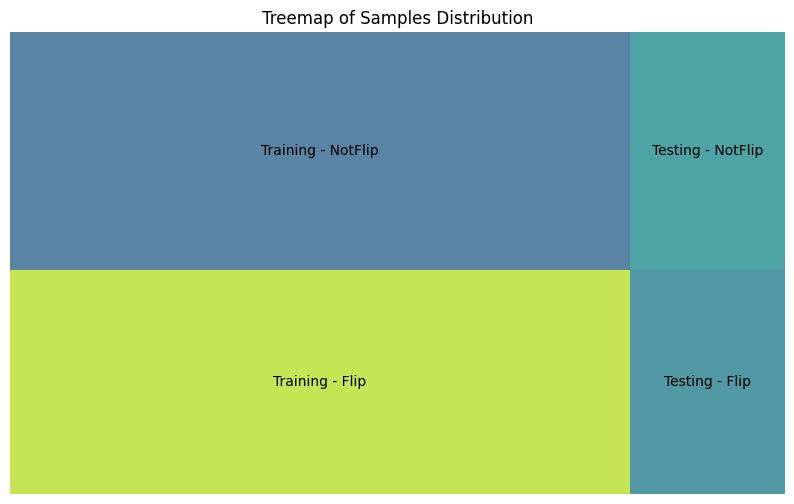

In [25]:
# Treemap Visualization
def plot_treemap(train_labels, test_labels):
    data = {
        'Training - Flip': train_labels.count('flip'),
        'Training - NotFlip': train_labels.count('notflip'),
        'Testing - Flip': test_labels.count('flip'),
        'Testing - NotFlip': test_labels.count('notflip')
    }
    labels = list(data.keys())
    sizes = list(data.values())

    plt.figure(figsize=(10, 6))
    squarify.plot(sizes=sizes, label=labels, alpha=0.8)
    plt.title('Treemap of Samples Distribution')
    plt.axis('off')
    plt.show()

plot_treemap(train_labels, test_labels)


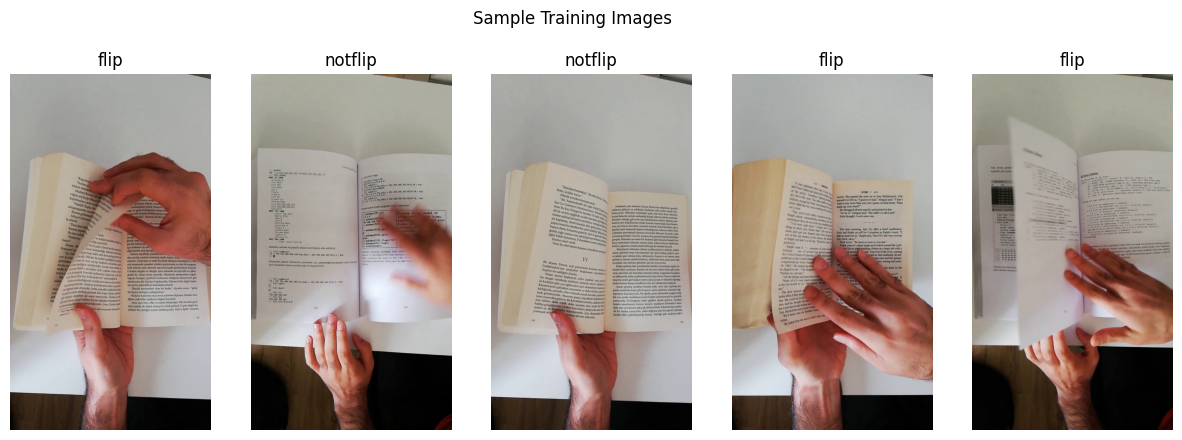

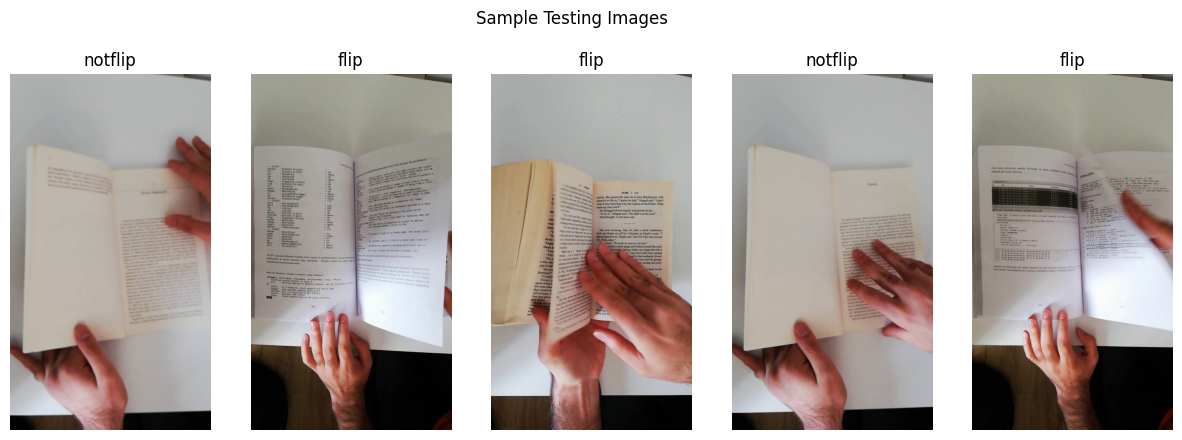

In [8]:
# Display sample images
def show_sample_images(image_paths, labels, title, num_samples=5):
    plt.figure(figsize=(15, 5))
    indices = np.random.choice(range(len(image_paths)), num_samples, replace=False)
    for i, idx in enumerate(indices):
        img = cv2.imread(image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(labels[idx])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_sample_images(train_paths, train_labels, "Sample Training Images")
show_sample_images(test_paths, test_labels, "Sample Testing Images")


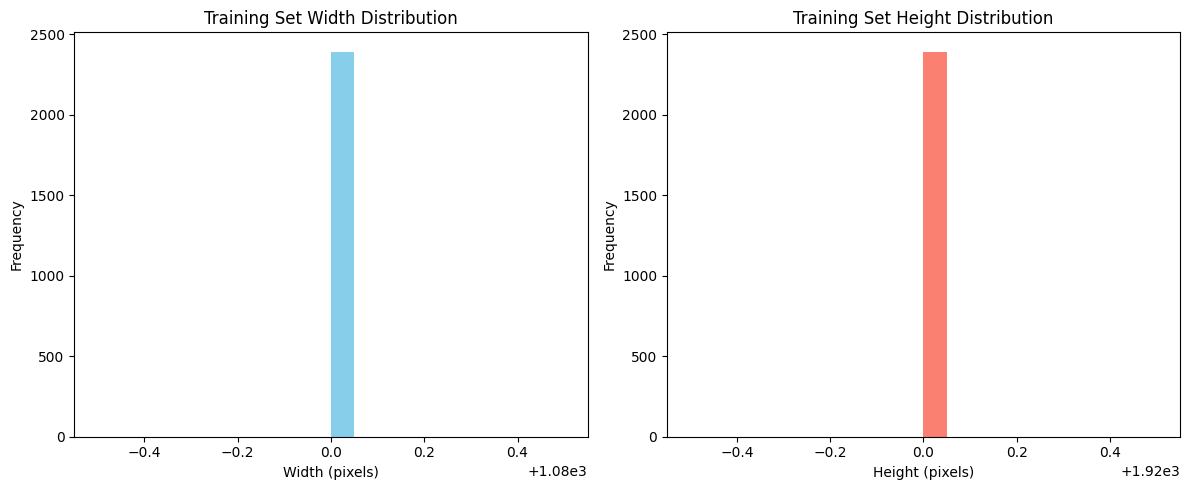

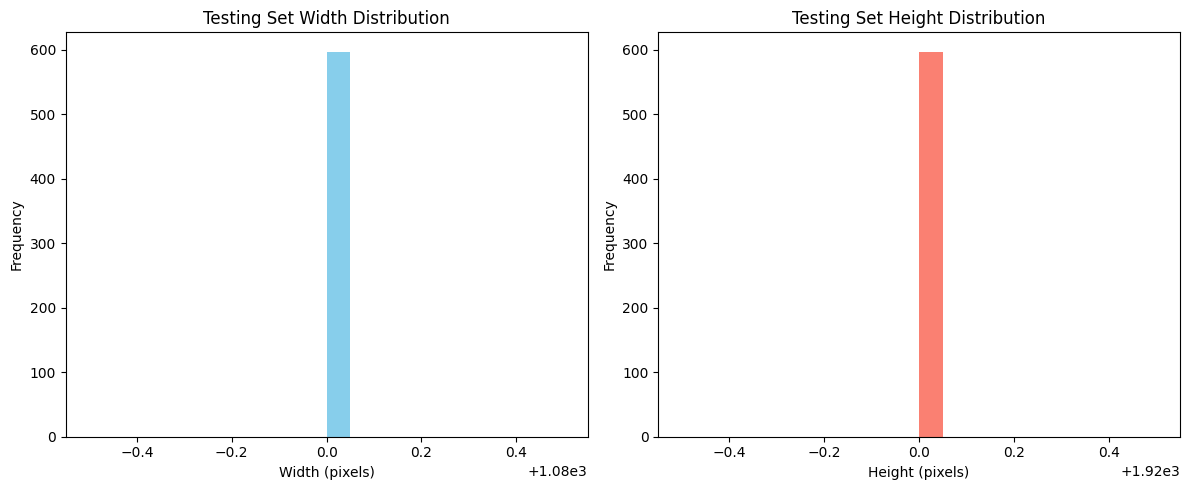

In [9]:
# Image size distribution

def image_size_distribution(image_paths, dataset_name="Dataset"):
    widths, heights = [], []
    for path in image_paths:
        img = cv2.imread(path)
        h, w, _ = img.shape
        widths.append(w)
        heights.append(h)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(widths, bins=20, color='skyblue')
    plt.title(f'{dataset_name} Width Distribution')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Frequency')

    plt.subplot(1, 2, 2)
    plt.hist(heights, bins=20, color='salmon')
    plt.title(f'{dataset_name} Height Distribution')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

image_size_distribution(train_paths, "Training Set")
image_size_distribution(test_paths, "Testing Set")

# Image Size Distribution Description

An analysis of the image dimensions for both the training and testing sets shows that the images have highly consistent sizes.

## Observations

- **Training Set:**  
  The width and height distributions are sharply peaked around specific values, indicating that all training images share nearly identical dimensions.

- **Testing Set:**  
  Similarly, the testing images display minimal variation in width and height, confirming consistent sizing across the dataset.

## Implications

- **Simplified Preprocessing:**  
  No additional resizing or padding is needed when preparing the images for model training.

- **Efficient Model Design:**  
  Models can accept fixed-size input images, leading to faster training times and improved stability.

- **Reduced Variability:**  
  Uniform image sizes help the models focus more effectively on learning meaningful patterns associated with the flipping action, instead of compensating for varying input dimensions.

This consistency is highly beneficial for both conventional computer vision methods and deep learning approaches.


In [11]:
# Check for corrupted images
def check_corrupted_images(image_paths):
    corrupted = []
    for path in image_paths:
        try:
            img = cv2.imread(path)
            if img is None:
                corrupted.append(path)
        except:
            corrupted.append(path)
    return corrupted

corrupted_train = check_corrupted_images(train_paths)
corrupted_test = check_corrupted_images(test_paths)

print(f"Corrupted images in Training Set: {len(corrupted_train)}")
print(f"Corrupted images in Testing Set: {len(corrupted_test)}")

if corrupted_train:
    print("Training corrupted files:", corrupted_train)
if corrupted_test:
    print("Testing corrupted files:", corrupted_test)


Corrupted images in Training Set: 0
Corrupted images in Testing Set: 0


# Corrupted Images Check

## Observations

- **Training Set:**  
  No corrupted images were found. All 2,392 training images are readable and properly formatted.

- **Testing Set:**  
  No corrupted images were found. All 597 testing images are readable and properly formatted.


## 2. Conventional Computer Vision Approaches

In [27]:
# Function to load images and labels
def load_data(base_dir):
    images = []
    labels = []
    for label in ['flip', 'notflip']:
        class_dir = os.path.join(base_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
            labels.append(1 if label == 'flip' else 0)
    return np.array(images), np.array(labels)

In [28]:
# Load training and testing data
X_train_img, y_train = load_data(train_dir)
X_test_img, y_test = load_data(test_dir)


### 2.1. Feature Extraction + Classical Machine Learning

### 2.1.1. Feature Extraction

In [30]:
def extract_hog_features(images):
    features = []
    for img in images:
        feature = hog(img, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), block_norm='L2-Hys', feature_vector=True)
        features.append(feature)
    return np.array(features)

In [31]:
def extract_lbp_features(images):
    features = []
    for img in images:
        lbp = local_binary_pattern(img, P=8, R=1, method="uniform")
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        features.append(hist)
    return np.array(features)

In [32]:
def extract_pixel_features(images):
    return images.reshape(images.shape[0], -1)

In [33]:
# Extract features
feature_extractors = {
    'HOG': extract_hog_features,
    'LBP': extract_lbp_features,
    'Raw Pixels': extract_pixel_features
}


In [39]:
# Plot extracted features alongside the original image for a sample
def plot_features_sample(image, extractors):
    fig, axs = plt.subplots(1, len(extractors) + 1, figsize=(20, 5))

    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    for i, (name, extractor) in enumerate(extractors.items(), start=1):
        if name == 'Raw Pixels':
            feature_img = image
        elif name == 'HOG':
            feature, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8),
                                     cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
            feature_img = hog_image
        elif name == 'LBP':
            lbp = local_binary_pattern(image, P=8, R=1, method="uniform")
            feature_img = lbp

        axs[i].imshow(feature_img, cmap='gray')
        axs[i].set_title(f'{name} Features')
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()



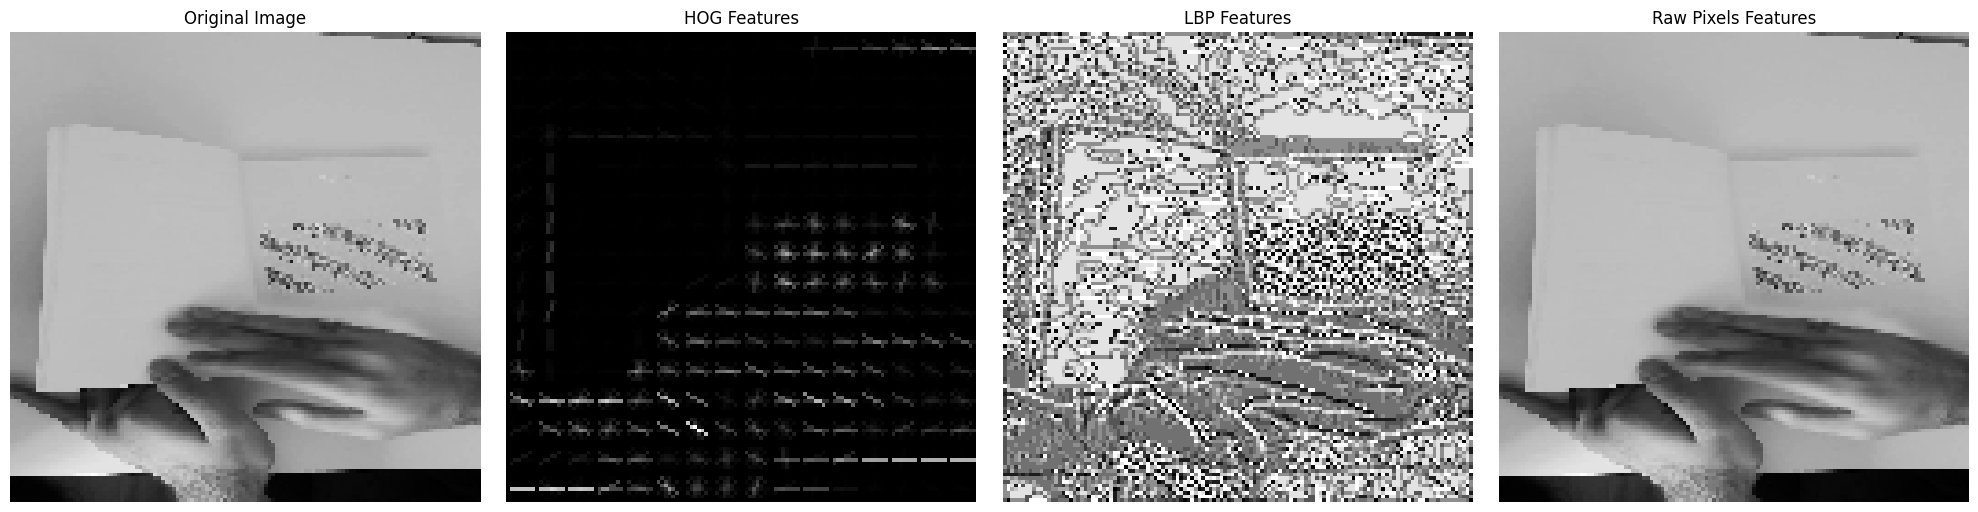

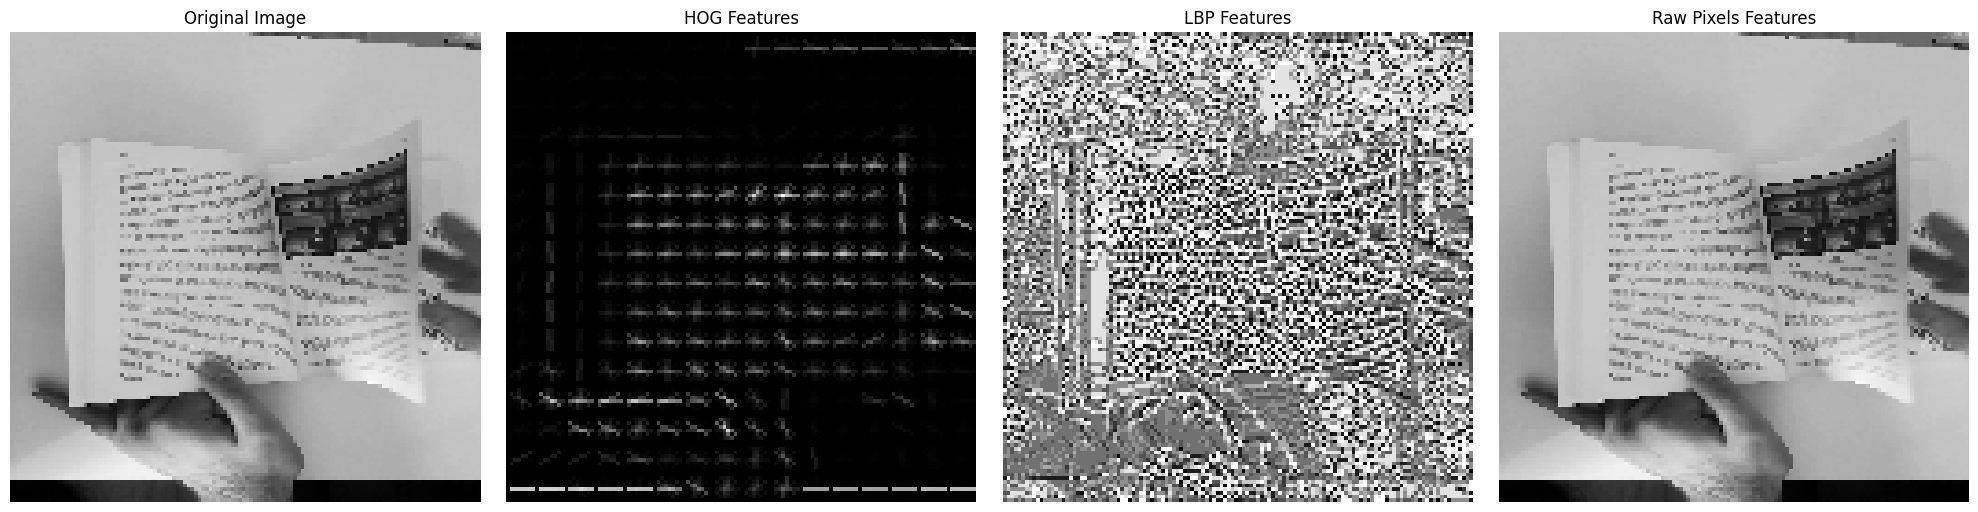

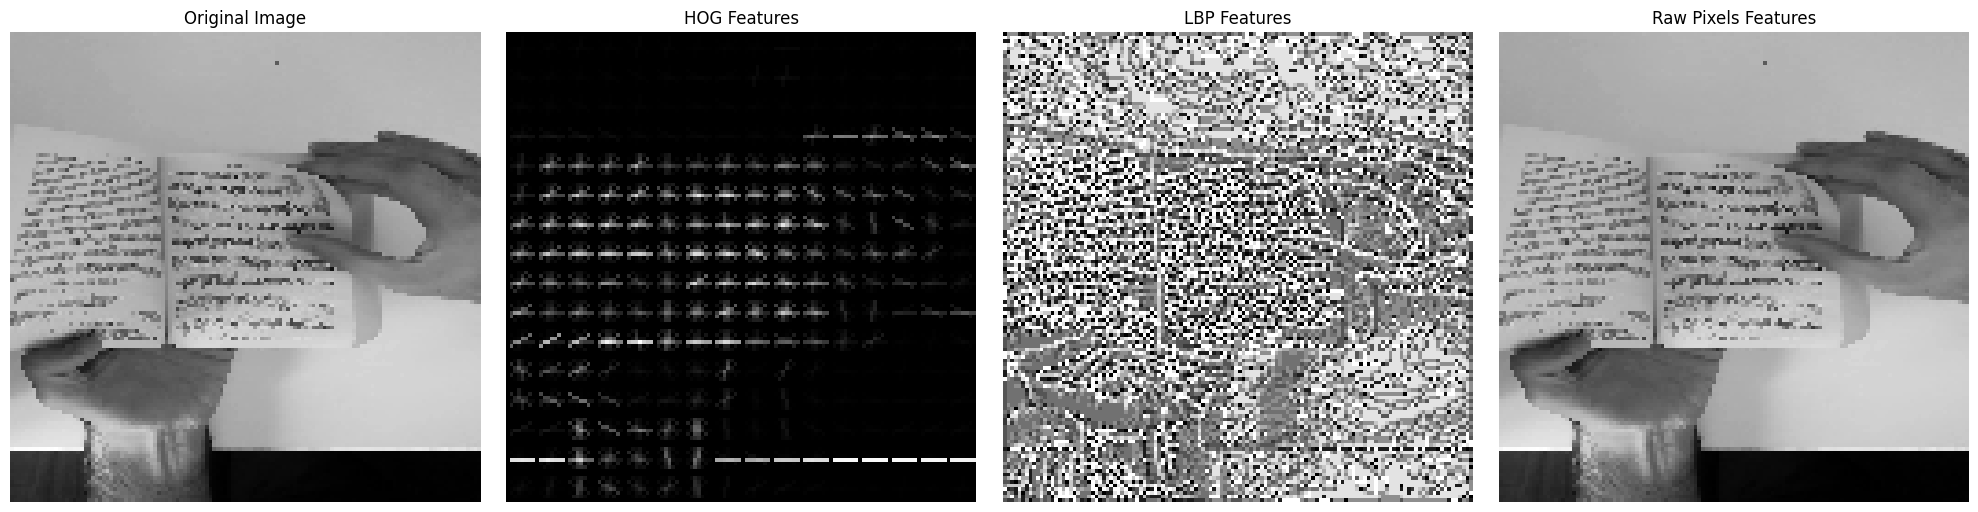

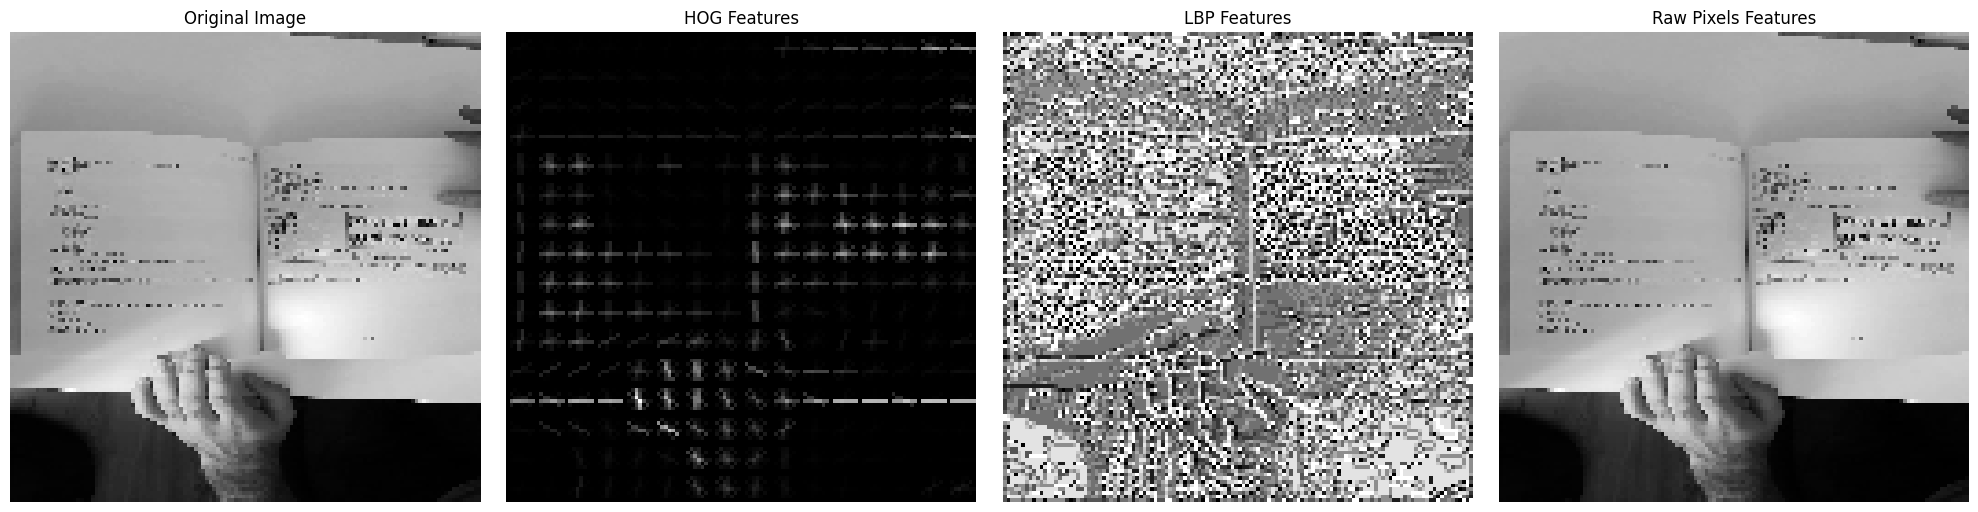

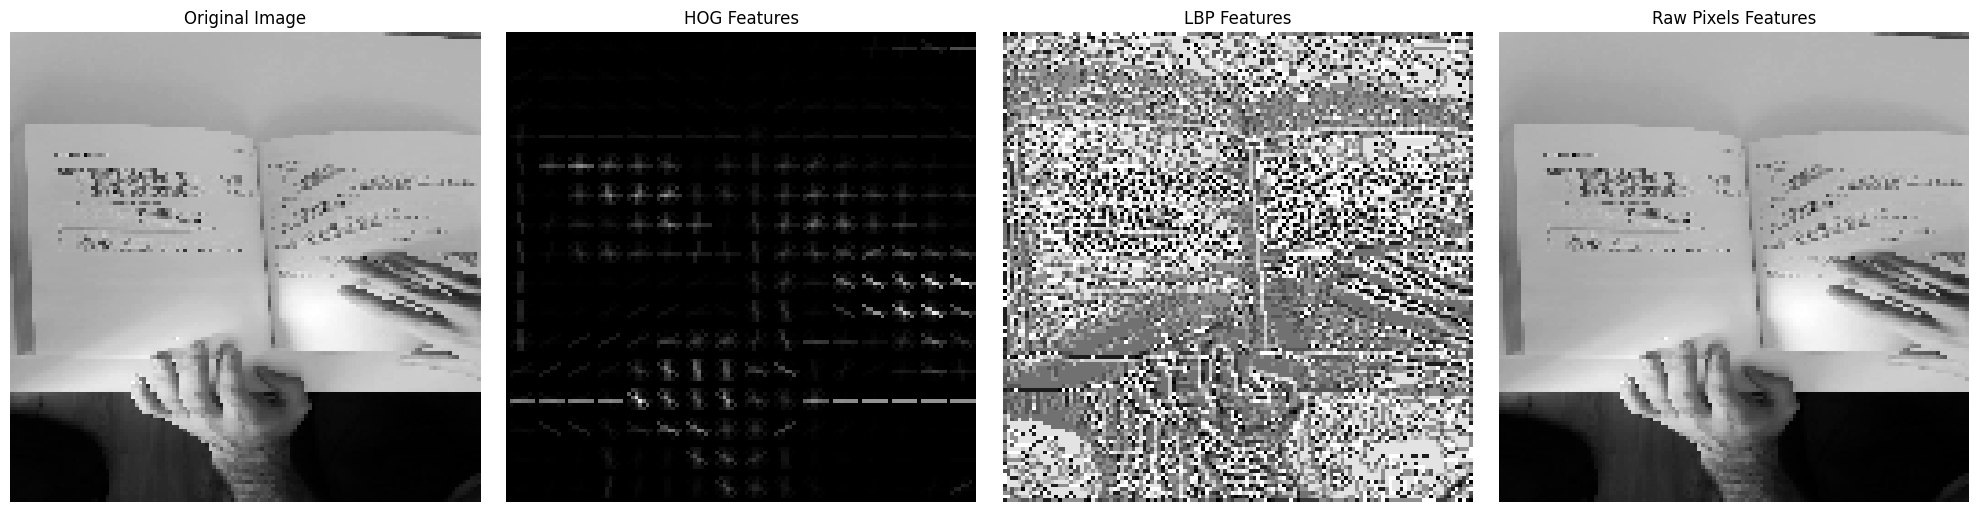

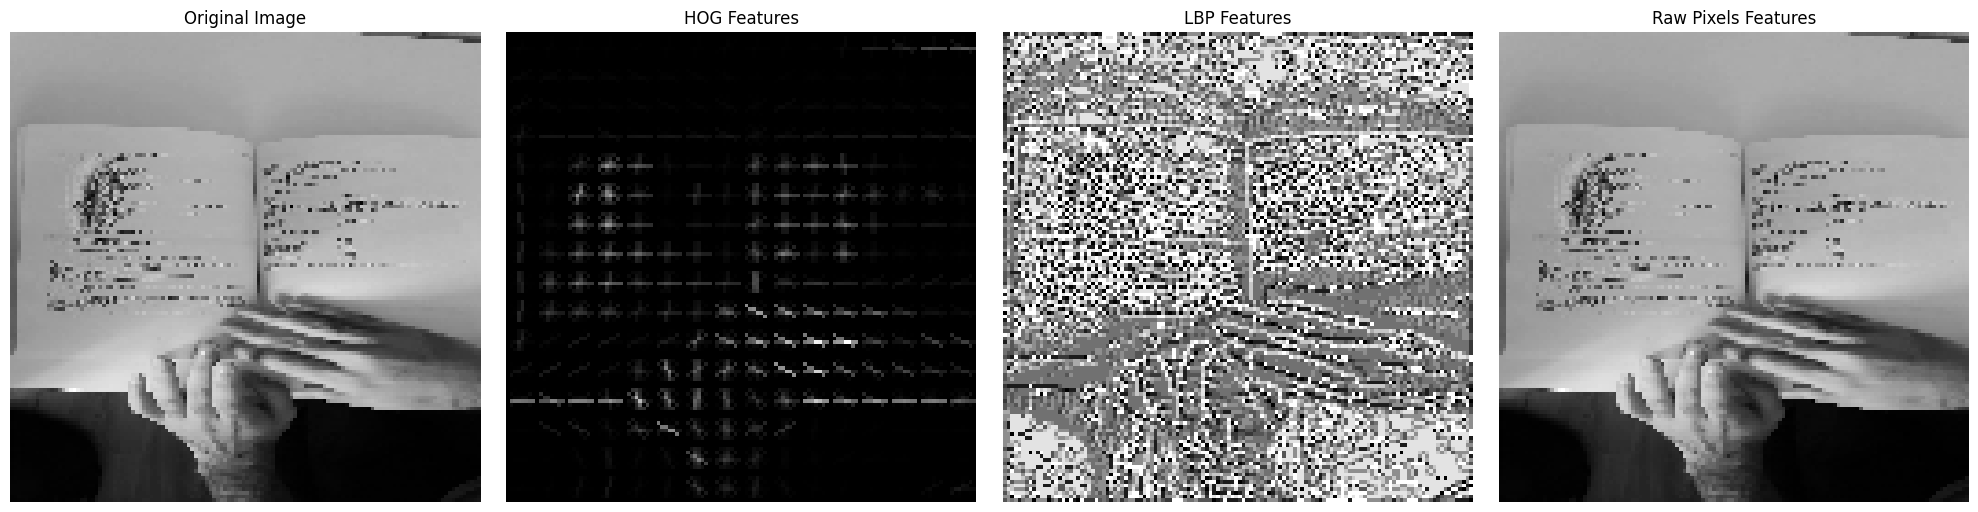

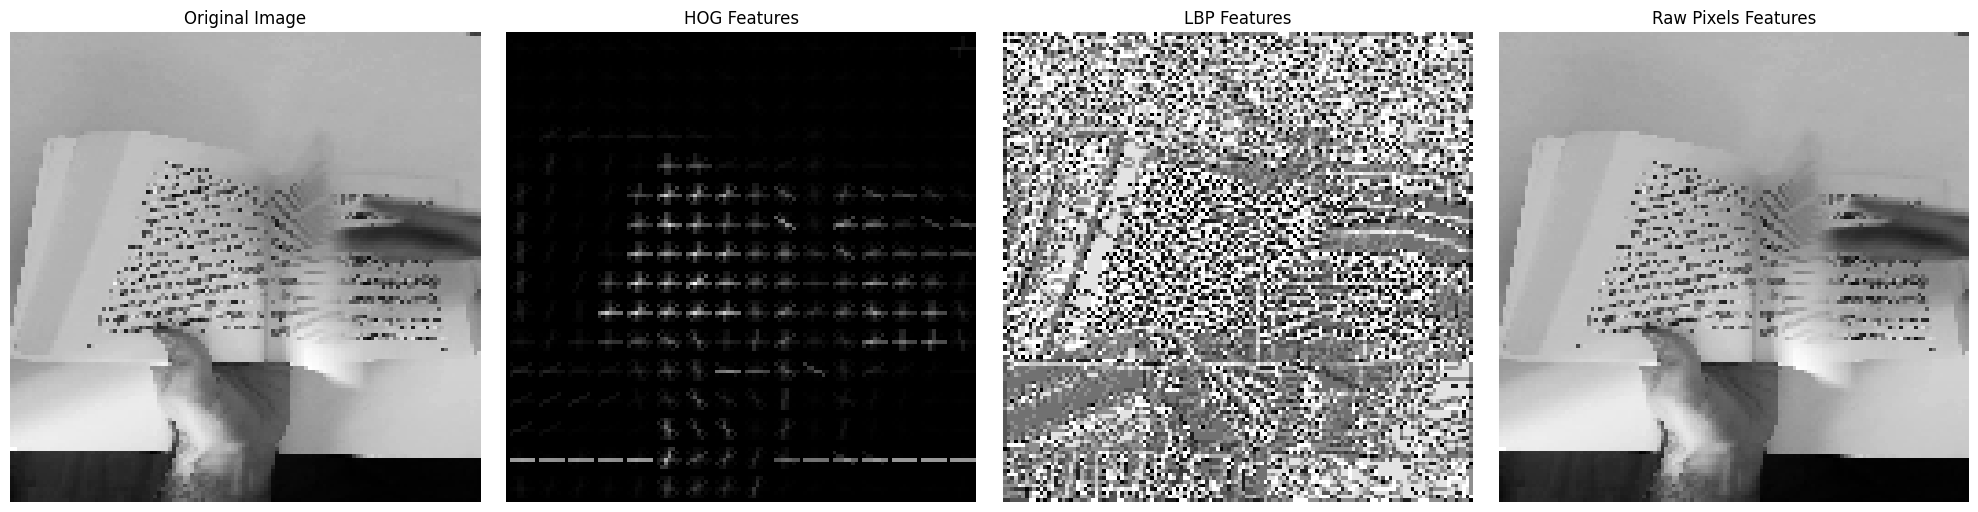

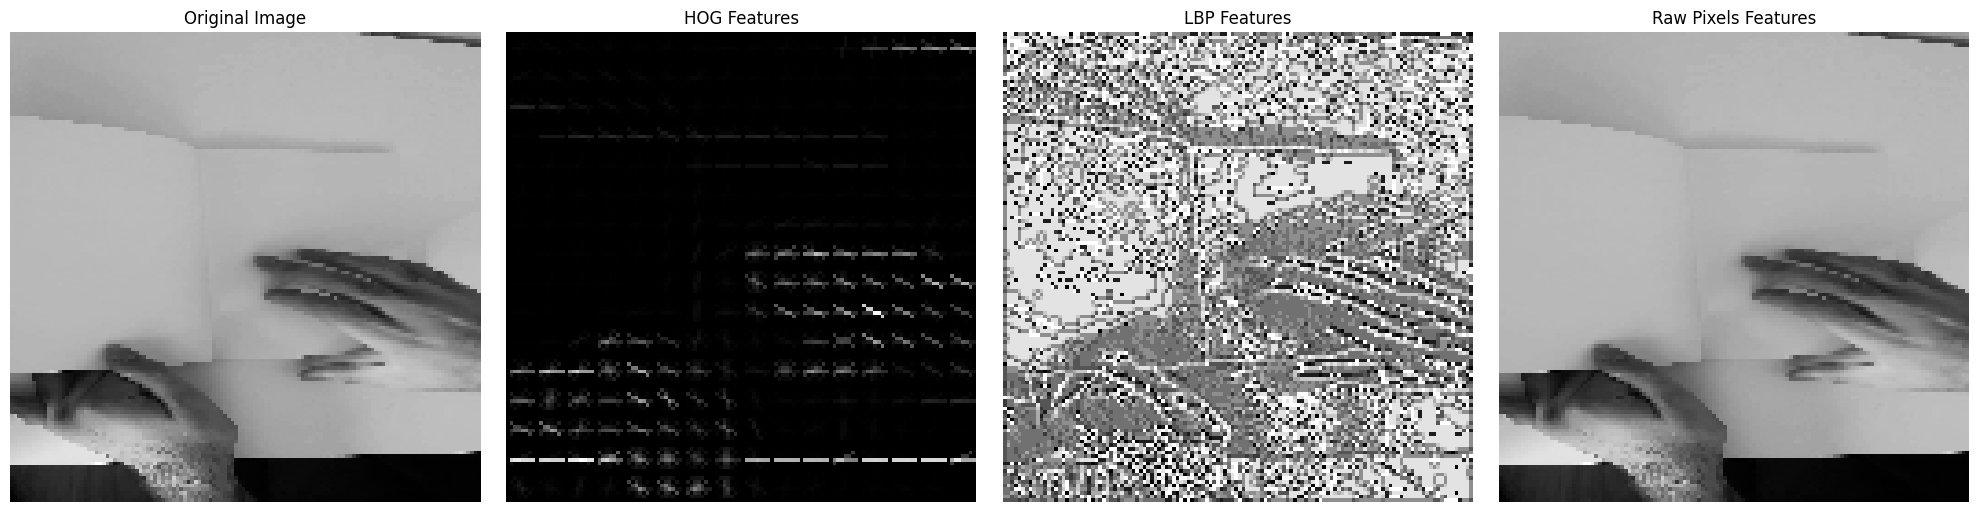

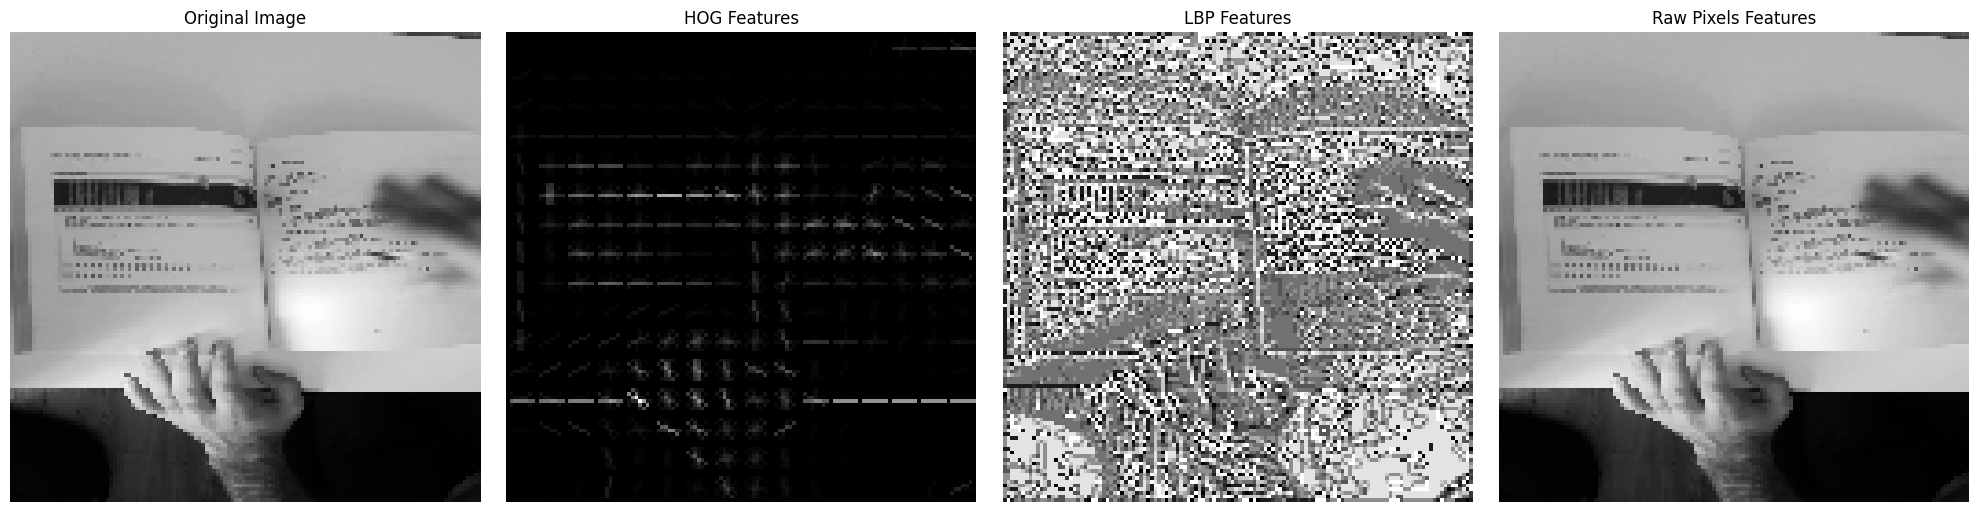

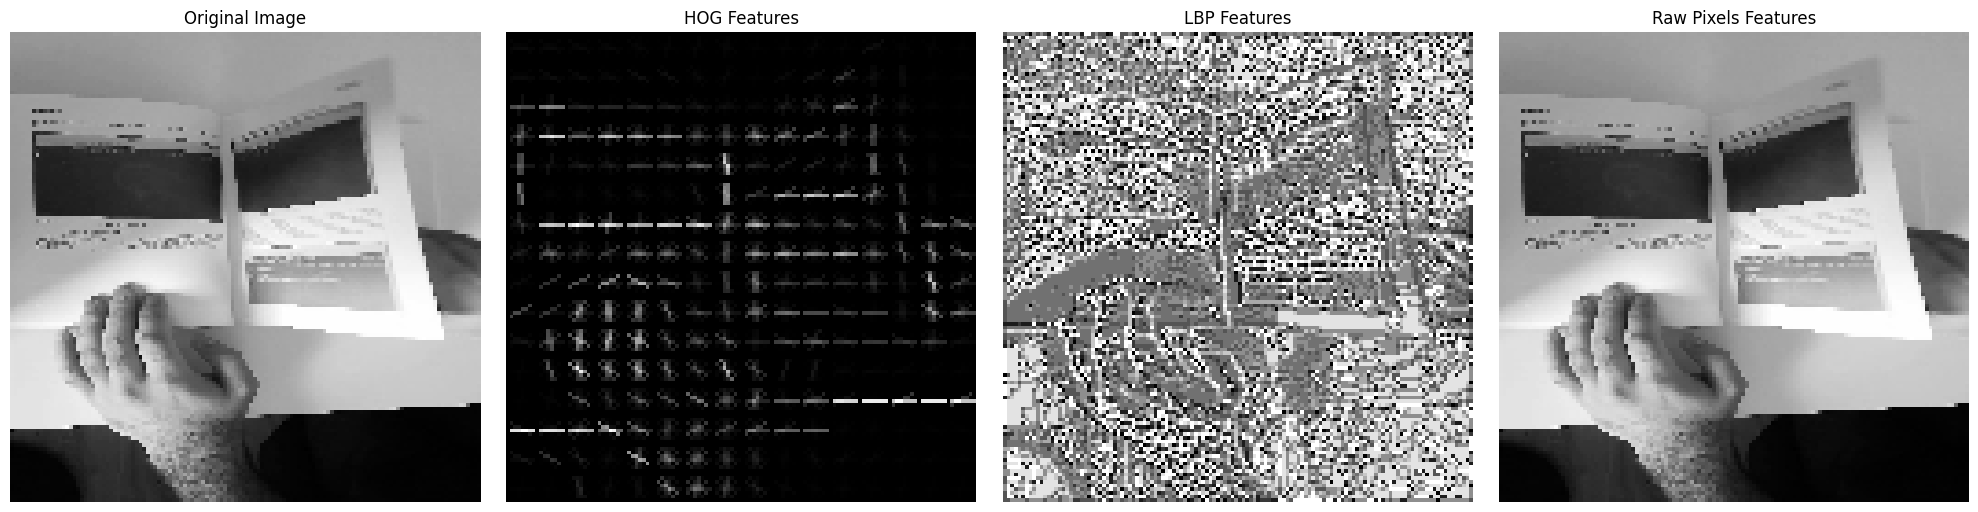

In [41]:
# Plot features for 10 random sample images
random_indices = np.random.choice(len(X_train_img), 10, replace=False)
for idx in random_indices:
    plot_features_sample(X_train_img[idx], feature_extractors)

In [34]:
# Define models
models = {
    'SVM': SVC(kernel='linear', random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'kNN': KNeighborsClassifier(n_neighbors=5)
}

In [42]:
# Train and evaluate
results = {}

for feat_name, feat_extractor in feature_extractors.items():
    X_train_feat = feat_extractor(X_train_img)
    X_test_feat = feat_extractor(X_test_img)

    model_f1_scores = {}

    for model_name, model in models.items():
        model.fit(X_train_feat, y_train)
        y_pred = model.predict(X_test_feat)
        f1 = f1_score(y_test, y_pred)
        results[f'{feat_name} + {model_name}'] = f1
        model_f1_scores[model_name] = f1
        print(f"{feat_name} + {model_name}: F1 Score = {f1:.4f}")


HOG + SVM: F1 Score = 0.9948
HOG + Random Forest: F1 Score = 0.9879
HOG + Logistic Regression: F1 Score = 0.9913
HOG + kNN: F1 Score = 0.9948
LBP + SVM: F1 Score = 0.6809
LBP + Random Forest: F1 Score = 0.8479
LBP + Logistic Regression: F1 Score = 0.6268
LBP + kNN: F1 Score = 0.8634
Raw Pixels + SVM: F1 Score = 0.9983
Raw Pixels + Random Forest: F1 Score = 0.9878
Raw Pixels + Logistic Regression: F1 Score = 0.9861
Raw Pixels + kNN: F1 Score = 0.9753


In [43]:
# Summarized F1 Scores by Model
model_summary = {}
for key, value in results.items():
    model = key.split('+')[-1].strip()
    model_summary[model] = model_summary.get(model, []) + [value]

average_model_scores = {k: np.mean(v) for k, v in model_summary.items()}


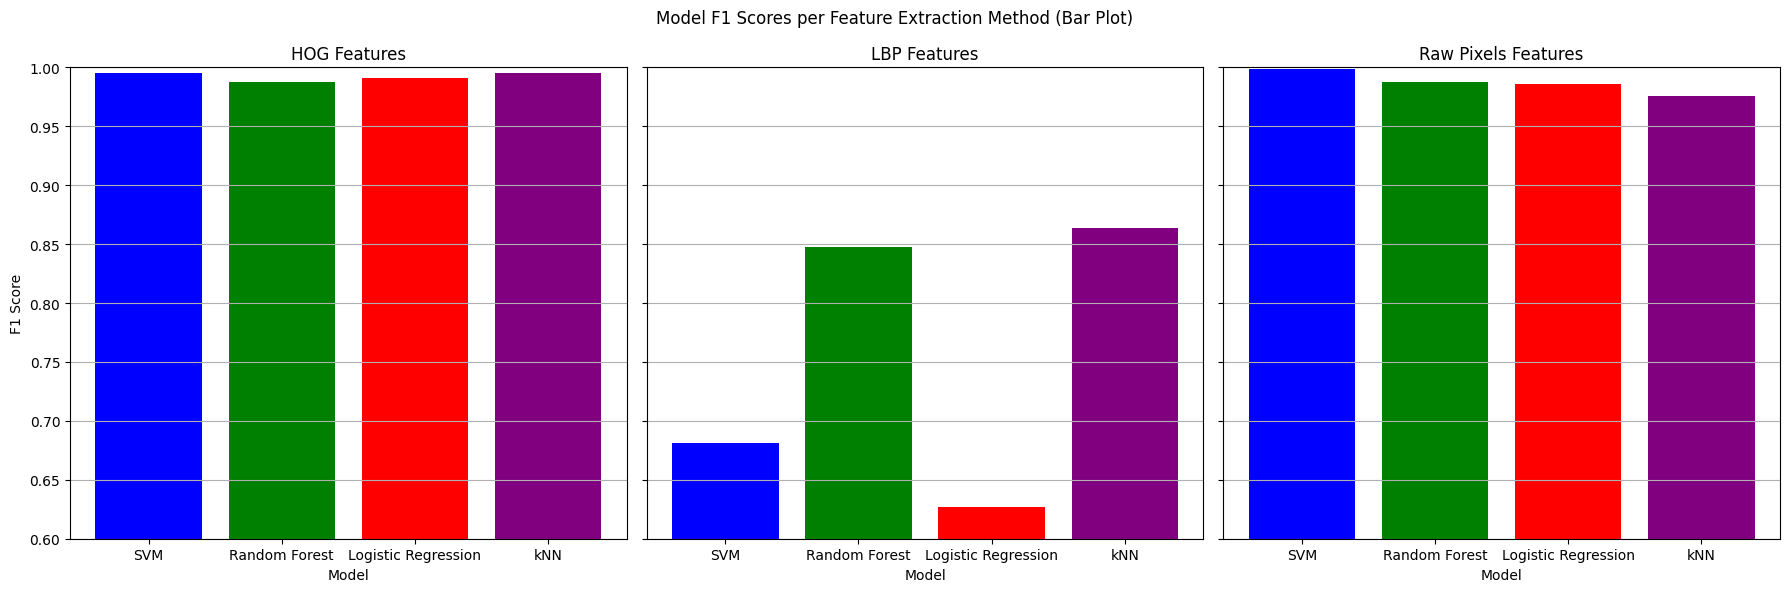

In [48]:
# Bar plot for all feature extraction and model combinations
fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
feature_names = list(feature_extractors.keys())
colors = ['blue', 'green', 'red', 'purple']

for idx, feat_name in enumerate(feature_names):
    ax = axs[idx]
    model_scores = {model_name: results[f'{feat_name} + {model_name}'] for model_name in models.keys()}
    ax.bar(model_scores.keys(), model_scores.values(), color=colors)
    ax.set_title(f'{feat_name} Features')
    ax.set_xlabel('Model')
    ax.set_ylim(0.6, 1)
    ax.grid(True, axis='y')
    if idx == 0:
        ax.set_ylabel('F1 Score')

plt.suptitle('Model F1 Scores per Feature Extraction Method (Bar Plot)')
plt.tight_layout()
plt.show()


### 2.2. Image Transformation + Thresholding

In [49]:
# Feature extraction function: Image Transformation + Thresholding
def extract_threshold_features(images):
    features = []
    for img in images:
        blurred = cv2.GaussianBlur(img, (5, 5), 0)
        _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        feature = thresh.flatten() / 255.0  # Normalize
        features.append(feature)
    return np.array(features)

In [50]:
# Feature extractor
feature_extractors = {
    'Threshold': extract_threshold_features
}

In [51]:
# Train and evaluate
results = {}

for feat_name, feat_extractor in feature_extractors.items():
    X_train_feat = feat_extractor(X_train_img)
    X_test_feat = feat_extractor(X_test_img)

    model_f1_scores = {}

    for model_name, model in models.items():
        model.fit(X_train_feat, y_train)
        y_pred = model.predict(X_test_feat)
        f1 = f1_score(y_test, y_pred)
        results[f'{feat_name} + {model_name}'] = f1
        model_f1_scores[model_name] = f1
        print(f"{feat_name} + {model_name}: F1 Score = {f1:.4f}")


Threshold + SVM: F1 Score = 0.9758
Threshold + Random Forest: F1 Score = 0.9772
Threshold + Logistic Regression: F1 Score = 0.9704
Threshold + kNN: F1 Score = 0.9564


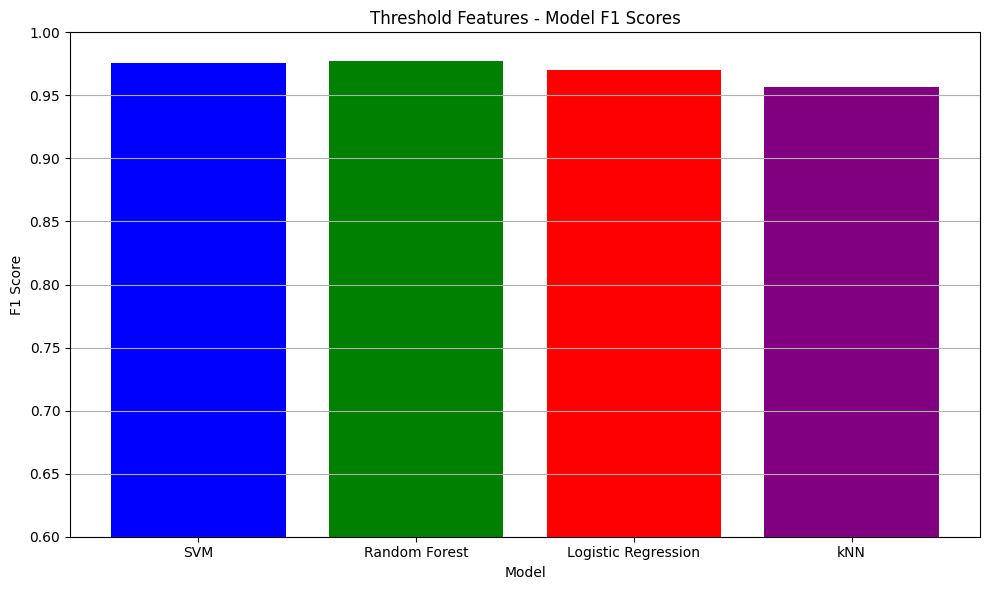

In [52]:
# Bar plot for Thresholding features
fig, ax = plt.subplots(figsize=(10, 6))
model_scores = {model_name: results[f'Threshold + {model_name}'] for model_name in models.keys()}
colors = ['blue', 'green', 'red', 'purple']
ax.bar(model_scores.keys(), model_scores.values(), color=colors)
ax.set_title('Threshold Features - Model F1 Scores')
ax.set_xlabel('Model')
ax.set_ylabel('F1 Score')
ax.set_ylim(0.6, 1)
ax.grid(True, axis='y')
plt.tight_layout()
plt.show()

## 3. Deep Learning Models

In [54]:
# Function to load images and labels
def load_data(base_dir):
    images = []
    labels = []
    for label in ['flip', 'notflip']:
        class_dir = os.path.join(base_dir, label)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(1 if label == 'flip' else 0)
    return np.array(images), np.array(labels)

X_train_img, y_train = load_data(train_dir)
X_test_img, y_test = load_data(test_dir)


In [61]:
# Custom Dataset
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # <- important change
        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(X_train_img, y_train, transform=transform)
test_dataset = ImageDataset(X_test_img, y_test, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [67]:
# Load pretrained ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 2)
resnet18 = resnet18.cuda()

In [57]:
# Define LeNet
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 29 * 29, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 29 * 29)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

lenet = LeNet().cuda()

In [58]:
# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.cuda(), labels.cuda()

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}')

In [59]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    preds = []
    targets = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            preds.extend(predicted.cpu().numpy())
            targets.extend(labels.cpu().numpy())
    return f1_score(targets, preds)

In [62]:
# Train and evaluate ResNet18
criterion = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(resnet18.parameters(), lr=0.001)
train_model(resnet18, train_loader, criterion, optimizer_resnet)
f1_resnet = evaluate_model(resnet18, test_loader)

Epoch [1/5], Loss: 0.2423
Epoch [2/5], Loss: 0.0671
Epoch [3/5], Loss: 0.0426
Epoch [4/5], Loss: 0.0030
Epoch [5/5], Loss: 0.0007


In [65]:
# Train and evaluate LeNet
optimizer_lenet = optim.Adam(lenet.parameters(), lr=0.001)
train_model(lenet, train_loader, criterion, optimizer_lenet)
f1_lenet = evaluate_model(lenet, test_loader)

Epoch [1/5], Loss: 0.6171
Epoch [2/5], Loss: 0.2958
Epoch [3/5], Loss: 0.1894
Epoch [4/5], Loss: 0.1061
Epoch [5/5], Loss: 0.0833


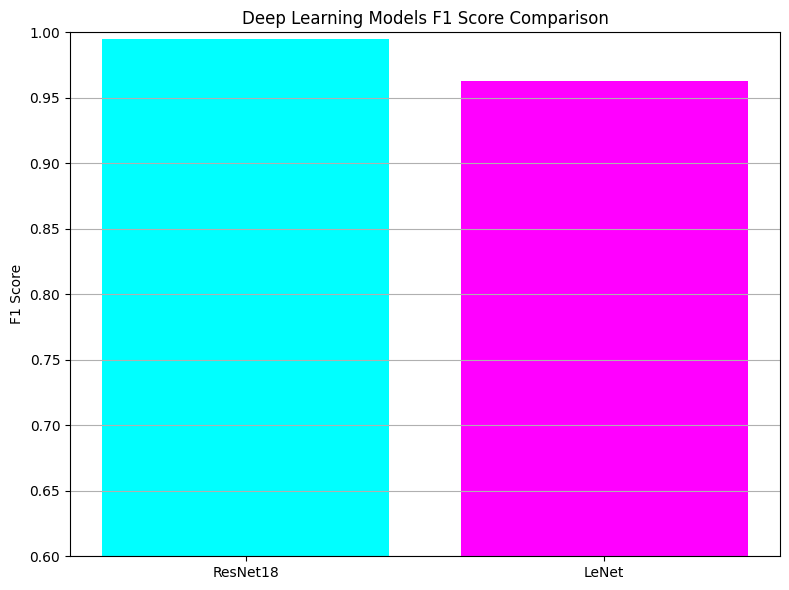

In [66]:
# Plot comparison
models_scores = {'ResNet18': f1_resnet, 'LeNet': f1_lenet}
plt.figure(figsize=(8, 6))
plt.bar(models_scores.keys(), models_scores.values(), color=['cyan', 'magenta'])
plt.title('Deep Learning Models F1 Score Comparison')
plt.ylabel('F1 Score')
plt.ylim(0.6, 1)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Read the text of images

# Tesseract OCR

In [17]:
#Test image
image_path = "/home/ali/Documents/oXEbXtpGwHbyckzP/images.zip/images/testing/flip/0001_000000020.jpg"
image = Image.open(image_path)

In [18]:

# OCR with Turkish language
text = pytesseract.image_to_string(image, lang='tur')

print("Extracted Text:")
print(text)

tts = gTTS(text=text, lang='tr')

# Save to a temporary file and play
with tempfile.NamedTemporaryFile(delete=True, suffix=".mp3") as fp:
    tts.save(fp.name)
    playsound(fp.name)

Extracted Text:
MUALLA

perverlerin olduğu ve bu servislerin hangi portlardan, yağa kalktığı pay
dolayı Nmap £ açık 1 Kapali port bularak da işletim sistemi tespiti ya

Firewall/1DS Atlatma Yöntemleri

lede makinede real yal güvenlik duvarı devrede ol Gü
atlatmak için bazı yöntemler yardır. Bu yöntemler aşağıdaki gibtir

“parametresi İle paketleri parç

lay güvenl yy

map -f 192.168.134;
masını sağlayabilirsiniz.

nmap -MTU 576 192.168.134: MTU param

netresi ile fstediğimiz Af
atayabiliyoruz. Buradaki örnekte MTU değe

nl 576 olarak ayarladık
nmap -D 192-168.1.21192.168,1.34:-D parametresini 1p Spooting işlem içi
anıyoruz. Hedef makineye 1P adresimiz 192.168. 21'i gibi paket yolluyoruz.

Scan Sonuçlarını Dosyaya Aktarma
Yukarıda anlatılanlar talimatlar doğrultusunda Nmap scanininiz! başlattınız, ge
sap sonucunun terminalde ekrana basılması yerine bir dosyaya aktarılmasını,
teyebilirsiniz. Nmap'i kodlayan abilerimiz bunları da düşünmüşler. Örnekler
olursak;

map -4S -ON cikti.bet 192.1

In [ ]:

with open(image_path, "rb") as image_file:
    encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

# Initialize the client
client = Groq(api_key="Groq API Key")

# Create the request
completion = client.chat.completions.create(
    model="meta-llama/llama-4-scout-17b-16e-instruct",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Return only characters in the text"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{encoded_image}"
                    }
                }
            ]
        }
    ],
    temperature=1,
    max_completion_tokens=1024,
    top_p=1,
    stream=False,
    stop=None,
)

# Print the output
print(completion.choices[0].message.content)
tts = gTTS(text=completion.choices[0].message.content, lang='tr')

# Save to a temporary file and play
with tempfile.NamedTemporaryFile(delete=True, suffix=".mp3") as fp:
    tts.save(fp.name)
    playsound(fp.name)

# Page Flip Detection and OCR Extraction

## Problem Summary

In this project, we tackled the task of detecting whether a page flip action occurs in an image, using frames captured from smartphone videos. The primary goal was to classify each frame into flip or not flip categories based on visual cues.

## Exploratory Data Analysis

Our exploratory analysis revealed that the dataset is highly consistent:

- All images are of uniform size.  
- The class distribution between flip and notflip categories is well-balanced.  
- No corrupted images were found, ensuring clean training and testing splits.  

The simple and clear nature of the dataset suggested that even lightweight models could perform well on this task.

## Model Performance and Analysis

After experimenting with multiple approaches, we found that:

- Pretrained ResNet18 achieved the highest F1 score, benefiting from strong feature extraction learned from large-scale pretraining.  
- Conventional machine learning models (e.g., SVM, Random Forest) combined with HOG features performed exceptionally well, reaching F1 scores above 95%.  
- Raw pixel features and thresholded images with classical models also showed very high classification accuracy.  
- LeNet, while simpler than ResNet18, achieved an F1 score above 95%, but slightly lower than the top-performing models.

## Key Observations

The strong performance across all models can be attributed to:

- Small dataset size – Limited variability makes the classification problem relatively easier.  
- Simplicity of the classification challenge – Page flipping introduces noticeable changes (e.g., motion blur, hand presence, corner distortions), which are easily detectable using simple features.

As a result, heavier CNN architectures are not recommended, as they tend to overfit without offering significant improvements. Lightweight models or conventional ML approaches are more suitable here.

## Final Stage: OCR-Based Text Extraction and Voice Playback

In the final phase of the project, we focused on extracting textual content from detected page frames, enabling tasks like document summarization and digital archiving.

We used two OCR approaches:

- **Tesseract OCR (via PyTesseract)**  
  A well-known open-source OCR engine that performed reliably on clean and well-lit frames.

- **Meta-LLaMA/LLaMA-4-Scout-17B-16E-Instruct**  
  A state-of-the-art vision-language foundation model. This model was especially effective in extracting text from noisy or partially blurred pages, outperforming conventional OCR in more challenging scenarios.

To further extend the usefulness of the system, the extracted text was converted into speech using Text-to-Speech (TTS) tools such as **gTTS** or **pyttsx3**. The resulting audio was automatically played, transforming the pipeline into a **fully integrated document narration system**.

## Overall Summary

- The binary classification of page flipping was solved effectively using both deep learning and traditional models.  
- The simplicity of the problem allowed lightweight approaches to excel.  
- Integrating OCR expanded the project's capabilities, enabling meaningful content extraction.  
- **By adding real-time voice output of the extracted text, the system became suitable for assistive reading tools, voice-based documentation, and audio-enhanced digital archives.**
